## Descripción del Proyecto.
La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción. La métrica RECM en el conjunto de prueba no debe ser superior a 48.

Instrucciones del proyecto.

- Descarga los datos y haz el remuestreo por una hora.
- Analiza los datos
- Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
- Prueba los datos usando la muestra de prueba y proporciona una conclusión.

Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Descripción del Proyecto.
La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción. La métrica RECM en el conjunto de prueba no debe ser superior a 48.

Instrucciones del proyecto.

- Descarga los datos y haz el remuestreo por una hora.
- Analiza los datos
- Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
- Prueba los datos usando la muestra de prueba y proporciona una conclusión.

Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

In [1]:
# %%
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

 Carga de los datos.

In [2]:
# %%
df_taxi = pd.read_csv(r'../../../datasets/taxi.csv')

 2. Análisis

 Observación general de los datos.

In [3]:
# %%
df_taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
# %%
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Obervamos que los datos se cargaron correctamente. 

El DataFrame 26 406 filas por 2 columnas, del cual no hay ningún registro nulo.

el tipo de valores que tiene nuestro dataframe es object e int64. Dado que tenemos una columa llamada datetime,

cambiar esta columna al formato correspondiente. También observamos el número de viajes registrados es

cada 10 minutos. 

 Obervación estadística de los datos.

In [5]:
# %%
df_taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


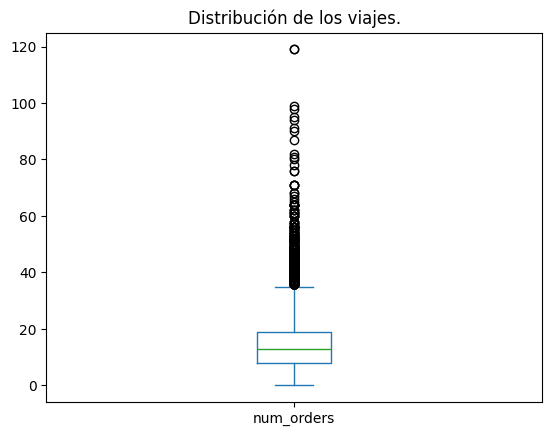

In [6]:
# %%
df_taxi.plot(kind='box', title='Distribución de los viajes.')
plt.show()

En la descripción estadística observamos que

los datos se encuentran ligeramente sesgados a la derecha; 

sin embargo, no es un problema para seguir adelante. El número total de viajes fue de 26,496, 

hubo registros con cero viajes, 

y la cantidad máxima de viajes en una hora y día específicos fue de 119. Tomemos en cuenta que aún no hacemos el remuestreo.

 Cambiar formato fecha y hacer remuestreo por una hora.

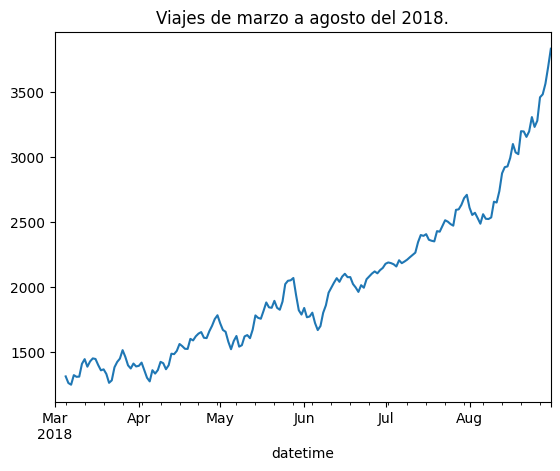

In [7]:
# %%
df_taxi['datetime'] = pd.to_datetime(df_taxi['datetime'])
df_taxi = df_taxi.set_index('datetime')
df_taxi = df_taxi.resample('1D').sum()
df = df_taxi.copy()
df['num_orders'].rolling(5).mean().plot(title="Viajes de marzo a agosto del 2018.")
plt.show()

In [34]:
df_taxi.describe()

,num_orders
count,184.000000
mean,2026.146739
std,635.874120
min,1076.000000
25%,1547.500000
50%,1911.500000
75%,2349.750000
max,4090.000000


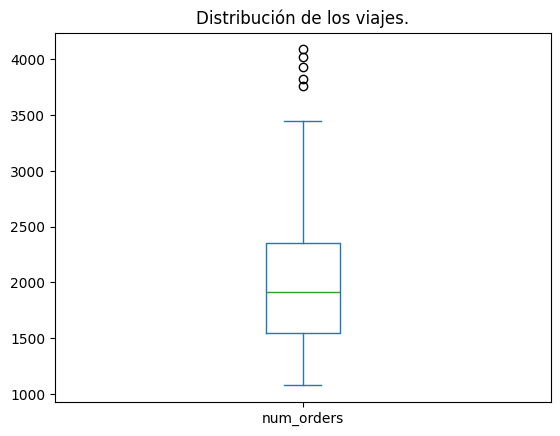

In [36]:
df_taxi.plot(kind='box', title='Distribución de los viajes.')
plt.show()

En la gráfica podemos observar la cantidad de viajes regitrados

de los días de marzo a agosto. Además suavizamos con promedio móvil la gráfica.

In [8]:
# %%
# Tendencia, estacionalidad y residuales.

Text(0.5, 1.0, 'Residuales')

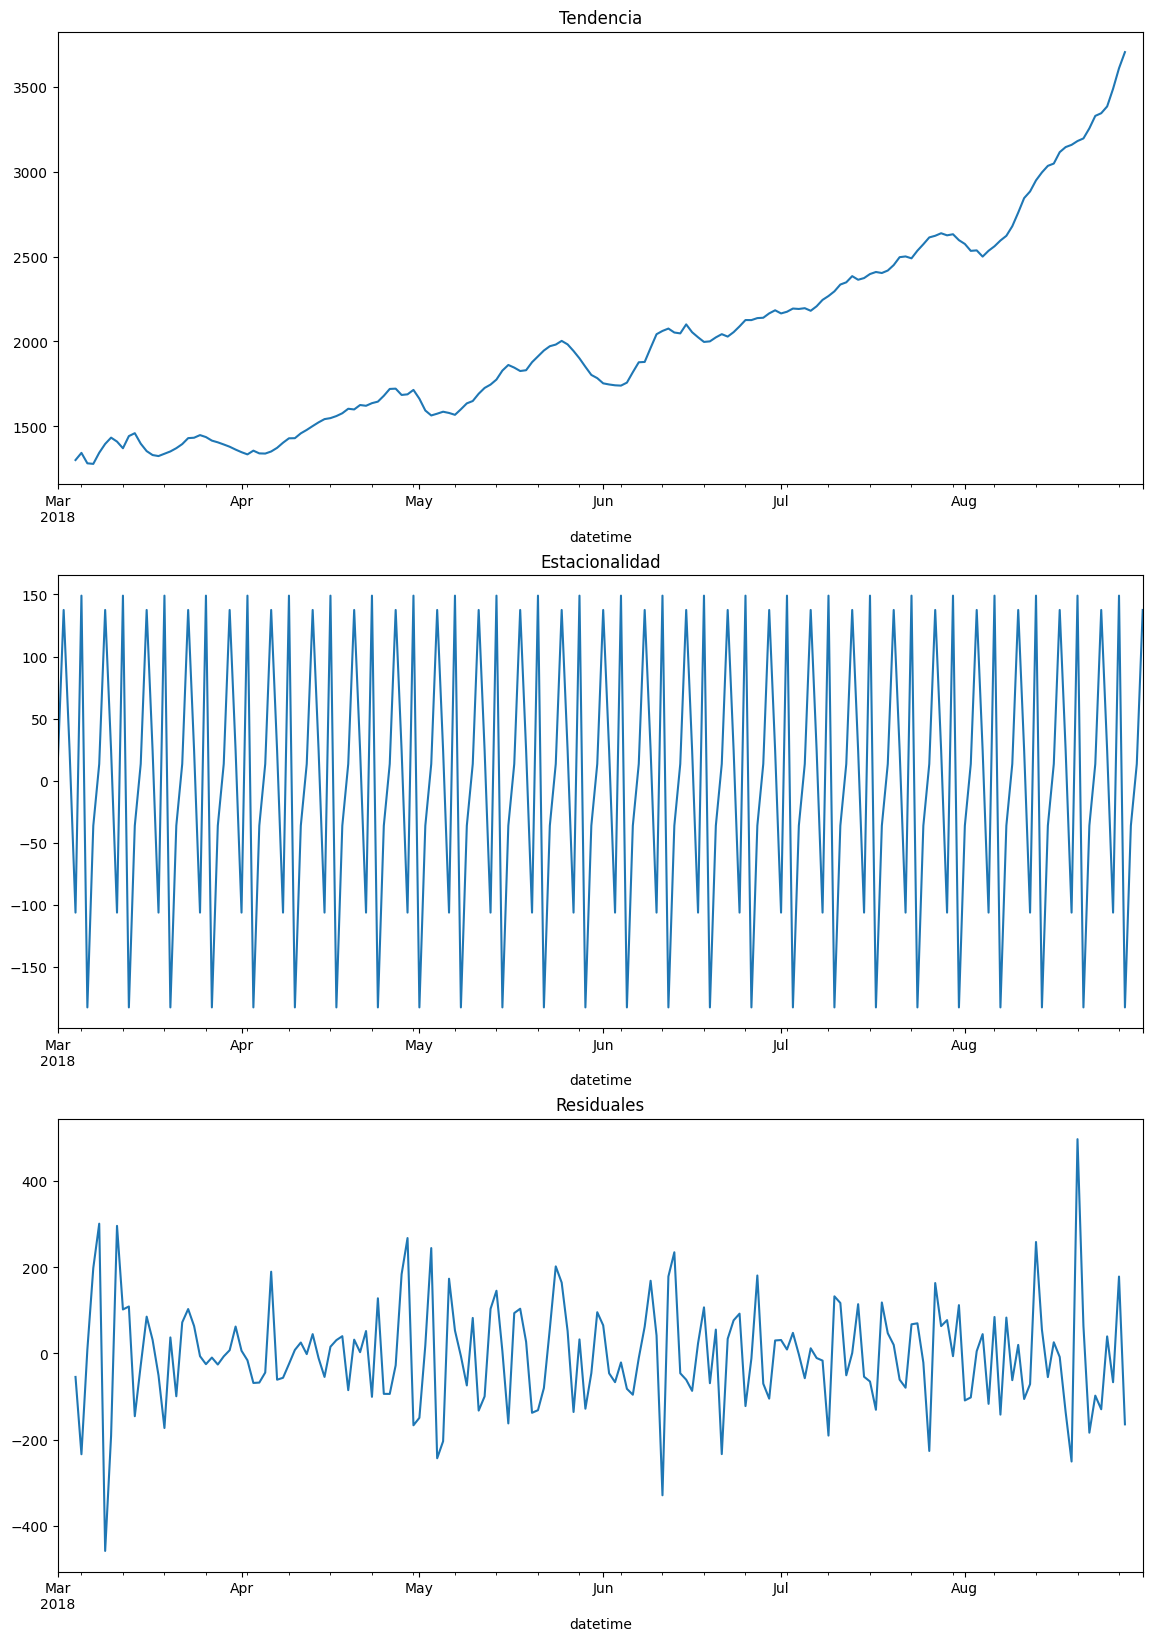

In [9]:
# %%
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(14, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')

 Hacer los datos mas estacionarios.

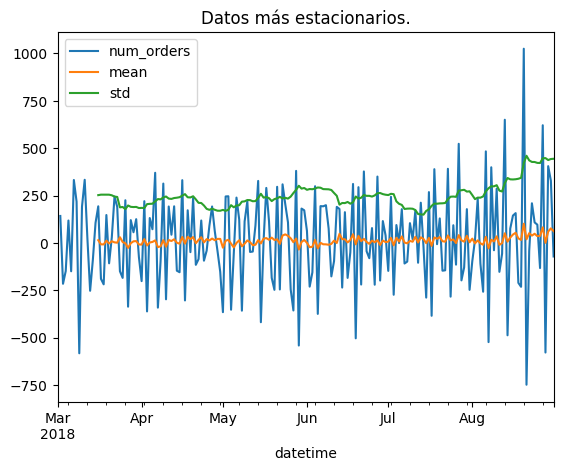

In [10]:
# %%
data = df[['num_orders']].copy()
data -= data.shift()

data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()

data.plot(title='Datos más estacionarios.')
plt.show()

In [11]:
# %% ['markdown]
### Escalar datos.
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

 Funciones.

In [12]:
# %%
# Gráfica promedio movil
def grafica_promedio_movil(data, predictions, target_train, target_test, title=''):
    pred_test = pd.Series(predictions, target_test.index)
    train_with_predictions = pd.concat([target_train, pred_test])

    train_predictions_rolling = train_with_predictions.rolling(15).mean()
    df_rolling = data['num_orders'].rolling(15).mean()

    plt.title(title)
    plt.plot(df_rolling, label="Datos originales")
    plt.plot(train_predictions_rolling.loc[test.index],
             label="Predicción")
    plt.legend()
    plt.show()
# Grafica RMSE


def grafica_rmse(rmse_list, title=''):
    plt.plot(rmse_list)
    plt.plot(np.argmin(rmse_list), np.min(rmse_list),
             marker='*', markersize=15,
             label=f"Mejor RMSE: {np.min(rmse_list):.2f}")
    plt.title(title)
    plt.legend()
    plt.show()
# Creación de características para los modelos.


def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek

    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = (
        new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    
    return new_data


 3. Formación

In [39]:
# %%
train, test = train_test_split(df, test_size=0.1, shuffle=False)

In [40]:
# %%
print(train)
print(test)

            num_orders
datetime              
2018-03-01        1364
2018-03-02        1506
2018-03-03        1290
2018-03-04        1141
2018-03-05        1259
...                ...
2018-08-08        2669
2018-08-09        2630
2018-08-10        2916
2018-08-11        2763
2018-08-12        2706

[165 rows x 1 columns]
            num_orders
datetime              
2018-08-13        3356
2018-08-14        2868
2018-08-15        2943
2018-08-16        3087
2018-08-17        3244
2018-08-18        3033
2018-08-19        2801
2018-08-20        3826
2018-08-21        3077
2018-08-22        3035
2018-08-23        3244
2018-08-24        3352
2018-08-25        3448
2018-08-26        3315
2018-08-27        3936
2018-08-28        3357
2018-08-29        3762
2018-08-30        4090
2018-08-31        4018


 Prueba

 Pruebas de cordura.

 Método 1.

In [57]:
rmse(test,pred_median)/df_taxi.median()[0]

C:\Users\CarlosVep\AppData\Local\Temp\ipykernel_13432\1398601029.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse(test,pred_median)/df_taxi.median()[0]


0.8280817113665827

In [62]:
# %%
print(f"Viajes medios al día: {np.median(df)}")
pred_median = np.ones(test.shape) * np.median(train)
print('RMSE:', rmse(test, pred_median))
print('% RMSE:', rmse(test,pred_median)/df_taxi.median().values[0])

Viajes medios al día: 1911.5
RMSE: 1582.8781912772229
% RMSE: 0.8280817113665827


 Método 2.

Nuestras prueba de cordura 1 tuvo un error demasiado grande, por otro lado, al segundo método, que aplicamos shifting,

le fue mejor pero no llegamos al objetivo RMSE que debe es 49. 

En los siguientes modelos haremos que este valor sea menor creando caracter´sitcas a partir de la serie temporal.

make_features(df, 10, 80)

 data_features = data.drop('num_orders',axis=1)

 data_target = data['num_orders']

 Regresión Lineal.

RMSE para el conjunto de prueba con max_lag 2 y max_rolling 4: 559.35
RMSE para el conjunto de prueba con max_lag 4 y max_rolling 8: 545.70
RMSE para el conjunto de prueba con max_lag 6 y max_rolling 12: 584.52
RMSE para el conjunto de prueba con max_lag 8 y max_rolling 16: 484.76
RMSE para el conjunto de prueba con max_lag 10 y max_rolling 20: 459.90
RMSE para el conjunto de prueba con max_lag 12 y max_rolling 24: 487.37
RMSE para el conjunto de prueba con max_lag 14 y max_rolling 28: 433.22
RMSE para el conjunto de prueba con max_lag 16 y max_rolling 32: 416.70
RMSE para el conjunto de prueba con max_lag 18 y max_rolling 36: 416.98
RMSE para el conjunto de prueba con max_lag 20 y max_rolling 40: 415.44
RMSE para el conjunto de prueba con max_lag 22 y max_rolling 44: 402.53
RMSE para el conjunto de prueba con max_lag 24 y max_rolling 48: 383.03
RMSE para el conjunto de prueba con max_lag 26 y max_rolling 52: 340.20
RMSE para el conjunto de prueba con max_lag 28 y max_rolling 56: 327.7

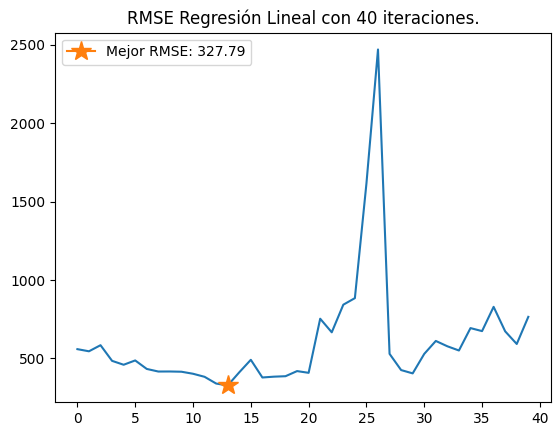

In [26]:
# %%
rmse_list = []
for x in range(40):
    new_data = make_features(df,2*(x+1),4*(x+1))
    train, test = train_test_split(new_data,
                              test_size=0.1,
                               shuffle=False,
                               random_state=1234)
    train = train.dropna()
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train[['num_orders']]
    features_test = test.drop(['num_orders'], axis=1)
    target_test = test[['num_orders']]

    model = LinearRegression()
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)}: {rmse(target_test, pred_test):.2f}')
    
    rmse_list.append(rmse(target_test, pred_test))
    
grafica_rmse(rmse_list,title="RMSE Regresión Lineal con 40 iteraciones.")

 Árboles de Decisión

RMSE para el conjunto de prueba con max_lag 2 y max_rolling 4: 1124.27
RMSE para el conjunto de prueba con max_lag 4 y max_rolling 8: 897.89
RMSE para el conjunto de prueba con max_lag 6 y max_rolling 12: 842.34
RMSE para el conjunto de prueba con max_lag 8 y max_rolling 16: 659.50
RMSE para el conjunto de prueba con max_lag 10 y max_rolling 20: 593.33
RMSE para el conjunto de prueba con max_lag 12 y max_rolling 24: 871.21
RMSE para el conjunto de prueba con max_lag 14 y max_rolling 28: 751.65
RMSE para el conjunto de prueba con max_lag 16 y max_rolling 32: 773.91
RMSE para el conjunto de prueba con max_lag 18 y max_rolling 36: 746.39
RMSE para el conjunto de prueba con max_lag 20 y max_rolling 40: 710.50
RMSE para el conjunto de prueba con max_lag 22 y max_rolling 44: 725.27
RMSE para el conjunto de prueba con max_lag 24 y max_rolling 48: 721.57
RMSE para el conjunto de prueba con max_lag 26 y max_rolling 52: 763.99
RMSE para el conjunto de prueba con max_lag 28 y max_rolling 56: 768.

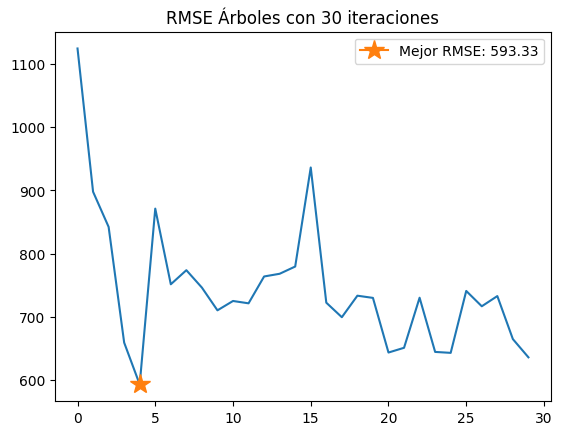

In [17]:
# %%
rmse_list = []
pred_test_list = []

for x in range(30):
    new_data = make_features(df,2*(x+1),4*(x+1))
    train, test = train_test_split(new_data,
                              test_size=0.1,
                               shuffle=False,
                               random_state=1234)
    train = train.dropna()
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train[['num_orders']]
    features_test = test.drop(['num_orders'], axis=1)
    target_test = test[['num_orders']]
    
    
    model = DecisionTreeRegressor(max_depth=x+1,
                                  random_state=1234)
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)}: {rmse(target_test, pred_test):.2f}')

    rmse_list.append(rmse(target_test, pred_test))
    pred_test_list.append(np.array(pred_test))
rmse_list = np.array(rmse_list)
pred_test_list = np.array(pred_test_list)
grafica_rmse(rmse_list, title="RMSE Árboles con 30 iteraciones")

In [18]:
# %%
# Random Forest

RMSE para el conjunto de prueba con max_lag 2 y max_rolling 4 en los datos y max_depth 1 en el modelo: 1119.17
RMSE para el conjunto de prueba con max_lag 4 y max_rolling 8 en los datos y max_depth 2 en el modelo: 884.15
RMSE para el conjunto de prueba con max_lag 6 y max_rolling 12 en los datos y max_depth 3 en el modelo: 832.04
RMSE para el conjunto de prueba con max_lag 8 y max_rolling 16 en los datos y max_depth 4 en el modelo: 756.40
RMSE para el conjunto de prueba con max_lag 10 y max_rolling 20 en los datos y max_depth 5 en el modelo: 781.33
RMSE para el conjunto de prueba con max_lag 12 y max_rolling 24 en los datos y max_depth 6 en el modelo: 749.38
RMSE para el conjunto de prueba con max_lag 14 y max_rolling 28 en los datos y max_depth 7 en el modelo: 756.96
RMSE para el conjunto de prueba con max_lag 16 y max_rolling 32 en los datos y max_depth 8 en el modelo: 734.71
RMSE para el conjunto de prueba con max_lag 18 y max_rolling 36 en los datos y max_depth 9 en el modelo: 750.

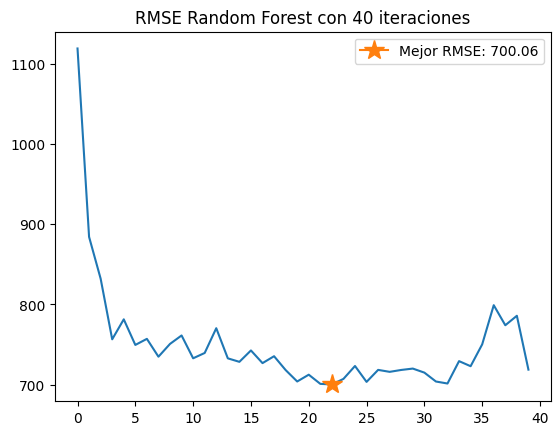

In [28]:
# %%
rmse_list = []
pred_test_list = []
for x in range(40):

    new_data = make_features(df,2*(x+1),4*(x+1))
    train, test = train_test_split(new_data,
                              test_size=0.1,
                               shuffle=False,
                               random_state=1234)
    
    train = train.dropna()
    
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train[['num_orders']]
    features_test = test.drop(['num_orders'], axis=1)
    target_test = test[['num_orders']]
    
    model = RandomForestRegressor(random_state=12345,
                                  criterion='squared_error',
                                  max_depth=x+1)
    
    model.fit(features_train, target_train.values.ravel())

    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} en los datos y max_depth {x+1} en el modelo:' 
          f' {rmse(target_test, pred_test):.2f}')

    rmse_list.append(rmse(target_test, pred_test))
    pred_test_list.append(np.array(pred_test))

rmse_list = np.array(rmse_list)
pred_test_list = np.array(pred_test_list)

grafica_rmse(rmse_list, title="RMSE Random Forest con 40 iteraciones")
# grafica_promedio_movil(data, pred_test_list[np.argmin(
#     rmse_list)-1], target_train, target_test, title="Promedio movil predicción con Random Forest")

 CatBoost

In [20]:
# %%
rmse_list = []
for x in range(30):
    
    new_data = make_features(df,2*(x+1),4*(x+1))
    train, test = train_test_split(new_data,
                              test_size=0.1,
                               shuffle=False,
                               random_state=1234)
    
    train = train.dropna()
    
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train[['num_orders']]
    features_test = test.drop(['num_orders'], axis=1)
    target_test = test[['num_orders']]
    
    model = CatBoostRegressor()
    # Con optimización automatizada de hiperparámetros. Facilita la búsqueda del mejor hiperparametros para un modelo.
    parameters = {'depth': [6, 8, 10],
                'learning_rate': [0.01, 0.05, 0.1],
                'iterations': [30, 50, 100]
                }

    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=2, n_jobs=-1)
    grid.fit(features_train, target_train)

    print(f"Los mejores parametros para CatBoost: {grid.best_params_}")
    model = CatBoostRegressor(**grid.best_params_)
    model.fit(features_train, target_train)
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} en los datos y {grid.best_params_} en el modelo:' 
          f' {rmse(target_test, pred_test):.2f}')
    
    rmse_list.append(rmse(target_test, pred_test))
    
rmse_list = np.array(rmse_list)

0:	learn: 418.1688015	total: 144ms	remaining: 7.05s
1:	learn: 392.7926457	total: 145ms	remaining: 3.48s
2:	learn: 368.3550994	total: 146ms	remaining: 2.28s
3:	learn: 349.6778415	total: 146ms	remaining: 1.68s
4:	learn: 333.1580534	total: 147ms	remaining: 1.32s
5:	learn: 313.4698755	total: 148ms	remaining: 1.08s
6:	learn: 296.2381306	total: 148ms	remaining: 911ms
7:	learn: 282.3102323	total: 149ms	remaining: 781ms
8:	learn: 268.2931070	total: 149ms	remaining: 681ms
9:	learn: 258.0237813	total: 150ms	remaining: 600ms
10:	learn: 246.2745628	total: 151ms	remaining: 534ms
11:	learn: 235.7085127	total: 151ms	remaining: 478ms
12:	learn: 227.4055571	total: 151ms	remaining: 431ms
13:	learn: 219.3943496	total: 152ms	remaining: 391ms
14:	learn: 211.7022835	total: 153ms	remaining: 356ms
15:	learn: 205.6376277	total: 153ms	remaining: 326ms
16:	learn: 199.8923188	total: 154ms	remaining: 299ms
17:	learn: 193.5201376	total: 154ms	remaining: 274ms
18:	learn: 187.4820564	total: 155ms	remaining: 253ms
19:

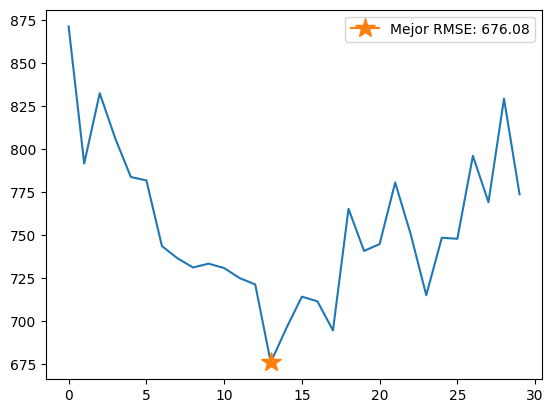

In [21]:
# %%
grafica_rmse(rmse_list)

 LGBMRegressor

d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 52, 20] before, using random point [0.007536377499951914, 3, 269, 133]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 52, 20] before, using random point [0.046327178785616874, 4, 282, 117]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 12, 52, 20] before, using random point [0.017710140576884064, 9, 65, 127]
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 161, number of used features: 6
[LightGBM] [Info] Start training from score 1886.447205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.03319778595032913, 11, 290, 136]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.0010038710048703287, 8, 91, 115]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.0017899550136806195, 4, 224, 131]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.0010869255519076184, 3, 121, 44]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been 

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 145, number of used features: 14
[LightGBM] [Info] Start training from score 1944.827586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.00042106660215566696, 6, 221, 56]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.00011497419019556015, 11, 169, 82]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.0030108355773025407, 7, 268, 103]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.024958290003951115, 10, 282, 83]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has be

[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 18
[LightGBM] [Info] Start training from score 1975.372263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.0014999618931674605, 10, 240, 101]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.007622741014854789, 12, 223, 92]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.0365632929030346, 6, 118, 136]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 3, 50, 20] before, using random point [0.00029755567227650955, 9, 105, 90]
  warnings.warn(
d:\Programs\Python\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been 

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 125, number of used features: 24
[LightGBM] [Info] Start training from score 2032.576000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

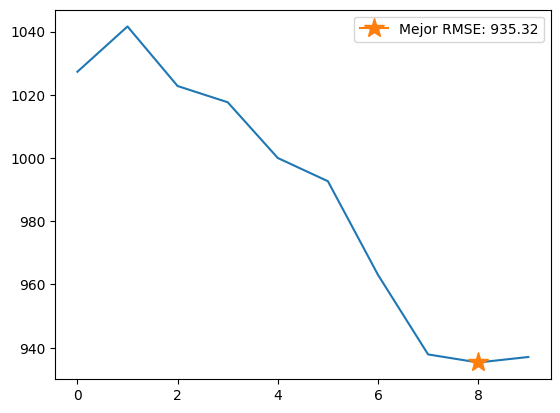

In [22]:
# %%
rmse_list = []
for x in range(10):
    
    new_data = make_features(df,2*(x+1),4*(x+1))
    train, test = train_test_split(new_data,
                              test_size=0.1,
                               shuffle=False,
                               random_state=1234)
    
    train = train.dropna()
    
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train[['num_orders']]
    features_test = test.drop(['num_orders'], axis=1)
    target_test = test[['num_orders']]
    
    model = LGBMRegressor()

    param_space = {
        'max_depth': (3, 12),
        'num_leaves': (20, 150),
        'learning_rate': (1e-4, 1e-1, 'log-uniform'),
        'min_data_in_leaf': (50, 300)
    }

    opt = BayesSearchCV(model, param_space, n_iter=50, cv=5, n_jobs=-1)
    opt.fit(features_train, target_train)

    print("Los mejores parametros para LightGBM: ", opt.best_params_)
    
    model = LGBMRegressor(**dict(opt.best_params_))
    model.fit(features_train, target_train)
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} en los datos y {opt.best_params_} en el modelo:' 
          f' {rmse(target_test, pred_test):.2f}')
    
    rmse_list.append(rmse(target_test, pred_test))
    
rmse_list = np.array(rmse_list)
grafica_rmse(rmse_list)

## XGBoost

RMSE para el conjunto de prueba con max_lag 2 y max_rolling 4 en los datos y con los hiperparametros seleccionados en el modelo: 809.91
RMSE para el conjunto de prueba con max_lag 4 y max_rolling 8 en los datos y con los hiperparametros seleccionados en el modelo: 807.76
RMSE para el conjunto de prueba con max_lag 6 y max_rolling 12 en los datos y con los hiperparametros seleccionados en el modelo: 953.89
RMSE para el conjunto de prueba con max_lag 8 y max_rolling 16 en los datos y con los hiperparametros seleccionados en el modelo: 880.87
RMSE para el conjunto de prueba con max_lag 10 y max_rolling 20 en los datos y con los hiperparametros seleccionados en el modelo: 916.72
RMSE para el conjunto de prueba con max_lag 12 y max_rolling 24 en los datos y con los hiperparametros seleccionados en el modelo: 845.39
RMSE para el conjunto de prueba con max_lag 14 y max_rolling 28 en los datos y con los hiperparametros seleccionados en el modelo: 760.50
RMSE para el conjunto de prueba con max_

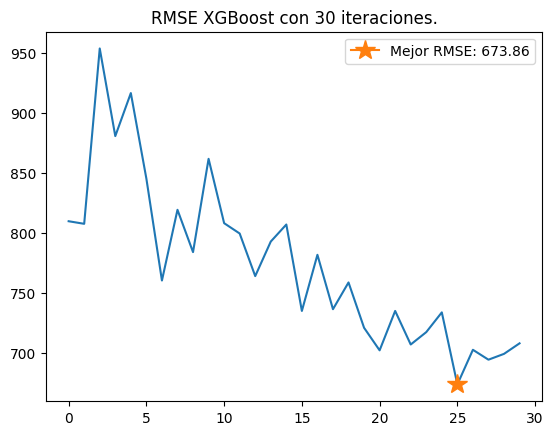

In [30]:
# %%
rmse_list = []
for x in range(30):

    new_data = make_features(df,2*(x+1),4*(x+1))
    train, test = train_test_split(new_data,
                              test_size=0.1,
                               shuffle=False,
                               random_state=1234)
    
    train = train.dropna()
    
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train[['num_orders']]
    features_test = test.drop(['num_orders'], axis=1)

    model =  XGBRegressor(alpha=0.1,
                          max_depth=5, 
                          eta=0.1, 
                          subsample=0.7, 
                          colsample_bytree=0.7, 
                          n_estimators = 100)
    model.fit(features_train, target_train)
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} en los datos y con los hiperparametros seleccionados en el modelo:' 
          f' {rmse(target_test, pred_test):.2f}')
    
    rmse_list.append(rmse(target_test, pred_test))
    
rmse_list = np.array(rmse_list)
grafica_rmse(rmse_list,title='RMSE XGBoost con 30 iteraciones.')

## AdaBoostRegressor

In [24]:
# %%
rmse_list = []
for x in range(30):

    new_data = make_features(df,2*(x+1),4*(x+1))
    train, test = train_test_split(new_data,
                              test_size=0.1,
                               shuffle=False,
                               random_state=1234)
    
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train[['num_orders']]
    features_test = test.drop(['num_orders'], axis=1)
    
    train = train.dropna()  
    
    model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=(x+1)),
                            n_estimators=1700, 
                            learning_rate=0.6, 
                            loss='exponential', random_state=42)
    model.fit(features_train, target_train.values.ravel())
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} en los datos y con los hiperparametros seleccionados en el modelo:' 
          f' {rmse(target_test, pred_test):.2f}')
    
    rmse_list.append(rmse(target_test, pred_test))
    
rmse_list = np.array(rmse_list)
grafica_rmse(rmse_list)

ValueError: Input X contains NaN.
AdaBoostRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## SVR

In [ ]:
# %%
rmse_list = []
for x in range(80):

    new_data = make_features(df,1*(x+1),2*(x+1))
    train, test = train_test_split(new_data,
                              test_size=0.1,
                               shuffle=False,
                               random_state=1234)
    
    train = train.dropna() 
    
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train[['num_orders']]
    features_test = test.drop(['num_orders'], axis=1) 
    
    model = SVR(C=1.0, epsilon=0.2)
    model.fit(features_train, target_train)
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} en los datos y con los hiperparametros seleccionados en el modelo:' 
          f' {rmse(target_test, pred_test):.2f}')
    
    rmse_list.append(rmse(target_test, pred_test))
    
rmse_list = np.array(rmse_list)
grafica_rmse(rmse_list)

## TODO MLP

In [ ]:
# %%
rmse_list = []
for x in range(30):
    
    new_data = make_features(df,1*(x+1),2*(x+1))
    train, test = train_test_split(new_data,
                              test_size=0.1,
                               shuffle=False,
                               random_state=1234)
    
    train = train.dropna() 
    
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train[['num_orders']]
    features_test = test.drop(['num_orders'], axis=1)
         
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (100, 100)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
        'learning_rate_init': [0.001, 0.01]
    }

    grid_search = GridSearchCV(MLPRegressor(random_state=1, max_iter=500), param_grid, cv=3, scoring='neg_root_mean_squared_error')
    grid_search.fit(features_train, target_train)

    print("Mejores parámetros encontrados:", grid_search.best_params_)    
    
    model = MLPRegressor(**grid_search.best_params_)
    model.fit(features_train, target_train.values.ravel())
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} en los datos y con los hiperparametros seleccionados en el modelo:' 
          f' {rmse(target_test, pred_test):.2f}')
    
    rmse_list.append(rmse(target_test, pred_test))
    
rmse_list = np.array(rmse_list)
grafica_rmse(rmse_list)
    
# pred_test = model.predict(features_test)
# print(F"RMSE MLP: {rmse(target_test,pred_test)}")

In [ ]:
# %%
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(model, features_train, target_train, cv=5, scoring='neg_root_mean_squared_error')
# print("RMSE promedio:", -scores.mean())

## Lasso

In [ ]:
# %%
from sklearn import linear_model
model = linear_model.Lasso(alpha=0.1)
model.fit(features_train, target_train)
pred_test = model.predict(features_test)
print(F"RMSE Lasso: {rmse(target_test,pred_test)}")

## ARDRegression

In [ ]:
# %%
from sklearn import linear_model
model = linear_model.ARDRegression(max_iter=800)
model.fit(features_train, target_train)
pred_test = model.predict(features_test)
print(F"RMSE Ridge: {rmse(target_test,pred_test)}")

## Poisson

In [ ]:
# %%
from sklearn import linear_model
model = linear_model.PoissonRegressor()
model.fit(features_train, target_train.values.ravel())
pred_test = model.predict(features_test)
print(F"RMSE Poisson: {rmse(target_test,pred_test)}")

## Perceptron

In [ ]:
# %%
from sklearn.linear_model import Perceptron
model = Perceptron(tol=1e-3, random_state=0, n_jobs=-1)
model.fit(features_train, target_train.values.ravel())
pred_test = model.predict(features_test)
print(F"RMSE Poisson: {rmse(target_test,pred_test)}")

## ElasticNetCV

In [ ]:
# %%
from sklearn.linear_model import ElasticNetCV
model =ElasticNetCV()
model.fit(features_train, target_train.values.ravel())
pred_test = model.predict(features_test)
print(F"RMSE ElasticNetCV: {rmse(target_test,pred_test)}")

## TODO: HuberRegressor

In [ ]:
# %%
from sklearn.linear_model import HuberRegressor
model = HuberRegressor(fit_intercept=False)
model.fit(features_train, target_train.values.ravel())
pred_test = model.predict(features_test)
print(F"RMSE HuberRegressor: {rmse(target_test,pred_test)}")

## RANSACRegressor

In [ ]:
# %%
from sklearn.linear_model import RANSACRegressor
model = RANSACRegressor()
model.fit(features_train, target_train.values.ravel())
pred_test = model.predict(features_test)
print(f"RMSE RANSACRegressor: {rmse(target_test,pred_test)}")

## KNeighborsRegressor

In [ ]:
# %%
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=30,weights='distance')
model.fit(features_train, target_train.values.ravel())
pred_test = model.predict(features_test)
print(F"RMSE KNeighborsRegressor: {rmse(target_test,pred_test)}")

## ExtraTreeRegressor

In [ ]:
# %%
from sklearn.tree import ExtraTreeRegressor
model = ExtraTreeRegressor(max_depth=1120,min_weight_fraction_leaf=0.2)
model.fit(features_train, target_train)
pred_test = model.predict(features_test)
print(f"RMSE ExtraTreeRegressor: {rmse(target_test,pred_test)}")

## HistGradientBoostingRegressor

In [ ]:
# %%
from sklearn.ensemble import HistGradientBoostingRegressor
model = HistGradientBoostingRegressor()
model.fit(features_train, target_train)
pred_test = model.predict(features_test)
print(f"RMSE HistGradientBoostingRegressor: {rmse(target_test,pred_test)}")

## StackingRegressor

In [ ]:
# %%
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=50,
                                          random_state=42)
)
reg.fit(features_train, target_train)
pred_test = model.predict(features_test)
print(f"RMSE StackingRegressor: {rmse(target_test,pred_test)}")

## BayesianRidge()

In [ ]:
# %%
from sklearn import linear_model
model = linear_model.BayesianRidge()
model.fit(features_train, target_train)
pred_test = model.predict(features_test)
print(f"RMSE BayesianRidge: {rmse(target_test,pred_test)}")


## TheilSenRegressor

In [ ]:
# %% 
from sklearn.linear_model import TheilSenRegressor
model = TheilSenRegressor()
model.fit(features_train, target_train)
pred_test = model.predict(features_test)
print(f"RMSE TheilSenRegressor: {rmse(target_test,pred_test)}")

## TODO MultiTaskLassoCV

In [ ]:
# %%
from sklearn.linear_model import MultiTaskLassoCV
model = MultiTaskLassoCV(cv=2)
model.fit(features_train, target_train)
pred_test = model.predict(features_test)
print(f"RMSE MultiTaskLassoCV: {rmse(target_test,pred_test)}")

## SGDClassifier

In [ ]:
# %%
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
model.fit(features_train, target_train)
pred_test = model.predict(features_test)
print(f"RMSE MultiTaskLassoCV: {rmse(target_test,pred_test)}")

 Lista de revisión

- [x] Jupyter Notebook está abierto.

- [x]  El código no tiene errores

- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.

- [x]  Los datos han sido descargados y preparados.

- [x]  Se ha realizado el paso 2: los datos han sido analizados

- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros

- [ ]  Se han evaluado los modelos. Se expuso una conclusión

- [ ]  La *RECM* para el conjunto de prueba no es más de 48"""

In [ ]:
# %%
